In [35]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import shap
shap.initjs()

# Read Dataset

,No,Weight (g),Roundness,Upper Petal,Lower Petal,Max Frequency (Hz),Max Magnitude,Sweetness (%Brix),Class
0,6.0,99.950000,0.895,4.0,6,184.490000,42.640000,19.250000,1
1,27.0,65.770000,0.894,4.0,6,179.250000,80.300000,21.000000,1
2,21.0,73.540000,0.900,4.0,6,176.630000,92.270000,20.750000,1
3,107.0,50.350000,0.969,4.0,7,172.020000,18.150000,18.625000,1
4,NaN,48.865201,0.939,NaN,5,211.624175,17.546100,22.623871,1
...,...,...,...,...,...,...,...,...,...
102,NaN,57.845846,0.958,NaN,5,168.468421,22.109954,17.017225,0
103,121.0,81.860000,0.967,4.0,7,137.000000,23.980000,17.125000,0
104,NaN,54.480048,0.940,NaN,6,98.542340,28.999338,12.628784,0
105,NaN,56.987053,0.959,NaN,5,169.178946,21.489349,13.258302,0


(107, 9)
1    54
0    53
Name: Class, dtype: int64


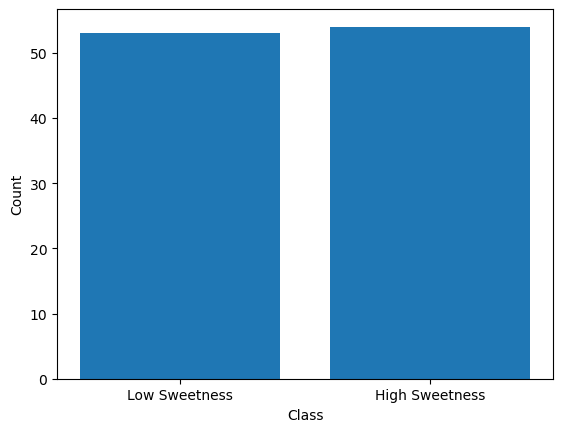

In [3]:
dataset = 'Dataset.xlsx'
sheet_name = 'GoodDataset'
export_good_bad_dataset = False
outlier_removal = False

if dataset == 'Dataset.xlsx':
    num = 0
    df = pd.read_excel(f'Dataset/{dataset}', sheet_name=sheet_name)
else:
    file = dataset.split('-')[0]
    num = dataset.split('-')[1].split('.')[0]
    df = pd.read_csv(f'Dataset/{dataset}')

# with pd.option_context('display.max_rows', 6): display(df)

display(df)

print(df.shape)

class_count = df['Class'].value_counts()
print(class_count)

plt.bar(['Low Sweetness', 'High Sweetness'], [class_count[0], class_count[1]])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Fill NaN with Mean

In [4]:
roundness_mean = df['Roundness'].mean()
max_frequency_mean = df['Max Frequency (Hz)'].mean()

print(f'Roundness Mean: {roundness_mean}')
print(f'Max Frequency (Hz) Mean: {max_frequency_mean}')

df['Roundness'].fillna(roundness_mean, inplace=True)
df['Max Frequency (Hz)'].fillna(max_frequency_mean, inplace=True)

Roundness Mean: 0.9465073088904865
Max Frequency (Hz) Mean: 128.0575718334945


# Features and Target Selection

In [5]:
feature = ['Weight (g)', 'Roundness', 'Lower Petal', 'Max Frequency (Hz)', 'Max Magnitude']
X = df[feature]
y = df['Sweetness (%Brix)']

# Dataset Visualization

## Pearson Correlation

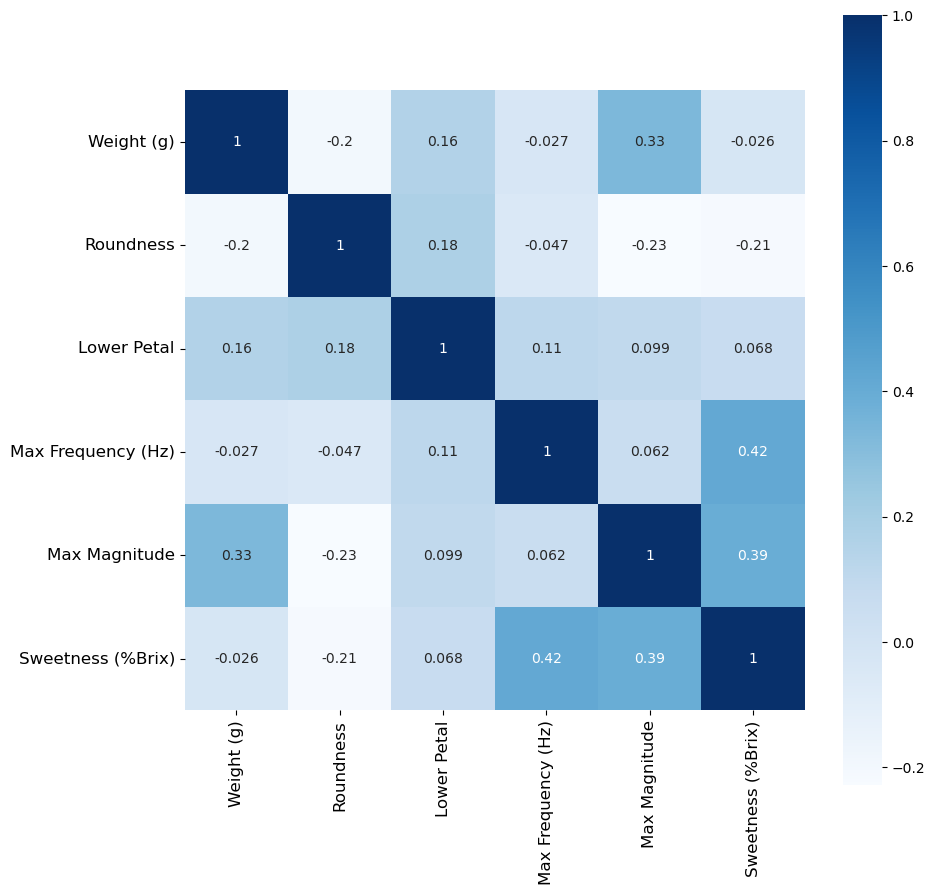

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[feature + ['Sweetness (%Brix)']].corr(), cmap="Blues", square=True, annot=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('pearson_correlation.pdf', dpi=600,bbox_inches='tight') 
plt.savefig('pearson_correlation.png', dpi=600, bbox_inches='tight')

plt.show() 

# Hyperparameter

In [15]:
cross_validation = KFold(n_splits=10, shuffle=True, random_state=42)

## KNN

In [16]:
standard_scaler = StandardScaler()

KNN = KNeighborsRegressor(n_jobs=-1)
KNN_parameter = {
    'model__leaf_size': list(range(1, 15)),
    'model__n_neighbors': list(range(1, 10, 2)),
    'model__p': np.arange(1.0, 3.0, 0.4),
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', KNN)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=KNN_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, 
                           verbose=0,
                           return_train_score=True)
grid_search.fit(X, y)

print('KNN Best Estimator: ', grid_search.best_estimator_)
print('KNN Best Parameter: ', grid_search.best_params_)
print('KNN Best Score: ', grid_search.best_score_)

KNN Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', KNeighborsRegressor(leaf_size=1, n_jobs=-1, p=1.0))])
KNN Best Parameter:  {'model__algorithm': 'auto', 'model__leaf_size': 1, 'model__n_neighbors': 5, 'model__p': 1.0, 'model__weights': 'uniform'}
KNN Best Score:  0.31499252702543107


In [17]:
KNN = grid_search.best_estimator_['model']
KNN

KNeighborsRegressor(leaf_size=1, n_jobs=-1, p=1.0)

## SVM

In [18]:
standard_scaler = StandardScaler()

SVM = SVR()
SVM_parameter = [
    {'model__kernel': ['linear'], 
     'model__C': np.arange(1.0, 3.0, 0.2)},
    {'model__kernel': ['rbf'], 
     'model__C': np.arange(1.0, 3.0, 0.2), 
     'model__gamma': list(range(1, 10))}
]

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', SVM)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=SVM_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('SVM Best Estimator: ', grid_search.best_estimator_)
print('SVM Best Parameter: ', grid_search.best_params_)
print('SVM Best Score: ', grid_search.best_score_)

SVM Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model', SVR(kernel='linear'))])
SVM Best Parameter:  {'model__C': 1.0, 'model__kernel': 'linear'}
SVM Best Score:  0.14732968281105313


In [19]:
SVM = grid_search.best_estimator_['model']
SVM

SVR(kernel='linear')

## Decision Tree

In [20]:
standard_scaler = StandardScaler()

DT = DecisionTreeRegressor(criterion='squared_error', random_state=42)
DT_parameter = {
    'model__max_depth': list(range(1, 15)),
    'model__max_leaf_nodes': list(range(2, 15))
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', DT)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=DT_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Decision Tree Best Estimator: ', grid_search.best_estimator_)
print('Decision Tree Best Parameter: ', grid_search.best_params_)
print('Decision Tree Best Score: ', grid_search.best_score_)

Decision Tree Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 DecisionTreeRegressor(max_depth=5, max_leaf_nodes=7,
                                       random_state=42))])
Decision Tree Best Parameter:  {'model__max_depth': 5, 'model__max_leaf_nodes': 7}
Decision Tree Best Score:  0.30640969811125396


In [21]:
DT = grid_search.best_estimator_['model']
DT

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=7, random_state=42)

## XGBoost

In [22]:
standard_scaler = StandardScaler()

XGB = XGBRegressor(learning_rate=0.02, objective='reg:squarederror', nthread=1)
XGB_parameter = {
    'model__min_child_weight': list(range(1, 5)),
    'model__gamma': list(range(1, 3)),
    'model__subsample': [0.2, 0.4, 0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__n_estimators': [500, 1000],
    'model__max_depth': list(range(1, 5))
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', XGB)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=XGB_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('XGBoost Best Estimator: ', grid_search.best_estimator_)
print('XGBoost Best Parameter: ', grid_search.best_params_)
print('XGBoost Best Score: ', grid_search.best_score_)

XGBoost Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=1.0, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=2, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.02,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None, min_child_weight=4,
                              missing=nan, monotone_constraints=None,
                              n_estimators=500, n_jobs=None, nthread=1,

In [23]:
XGB = grid_search.best_estimator_['model']
XGB

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, nthread=1, num_parallel_tree=None,
             predictor=None, ...)

## LightGBM

In [24]:
standard_scaler = StandardScaler()

LGBM = LGBMRegressor(learning_rate=0.02, objective='regression', n_jobs=-1, random_state=42)
LGBM_parameter = {
    'model__num_leaves': list(range(2, 5)),
    'model__max_depth': list(range(1, 4)),
    'model__n_estimators': [500, 1000],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', LGBM)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=LGBM_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('LightGBM Best Estimator: ', grid_search.best_estimator_)
print('LightGBM Best Parameter: ', grid_search.best_params_)
print('LightGBM Best Score: ', grid_search.best_score_)

LightGBM Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(learning_rate=0.02, max_depth=2,
                               n_estimators=500, num_leaves=4,
                               objective='regression', random_state=42))])
LightGBM Best Parameter:  {'model__colsample_bytree': 1.0, 'model__max_depth': 2, 'model__n_estimators': 500, 'model__num_leaves': 4}
LightGBM Best Score:  0.33769837952121234


In [25]:
LGBM = grid_search.best_estimator_['model']
LGBM

LGBMRegressor(learning_rate=0.02, max_depth=2, n_estimators=500, num_leaves=4,
              objective='regression', random_state=42)

## Artificial Neural Network

In [26]:
standard_scaler = StandardScaler()

ANN = MLPRegressor(max_iter=100000, random_state=42)
ANN_parameter = {
    'model__hidden_layer_sizes': [(2, 2), (3, 4), (4, 2), (4, 4)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['lbfgs', 'sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive']
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', ANN)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=ANN_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, verbose=0)
grid_search.fit(X, y)

print('Artificial Neural Network Best Estimator: ', grid_search.best_estimator_)
print('Artificial Neural Network Best Parameter: ', grid_search.best_params_)
print('Artificial Neural Network Best Score: ', grid_search.best_score_)

/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sippathamm/anaconda3/envs/ML/lib/pyt

/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:

/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sippathamm/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/sippathamm/anaconda3/envs/ML/lib/pyt

Artificial Neural Network Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 MLPRegressor(activation='logistic', hidden_layer_sizes=(2, 2),
                              learning_rate='adaptive', max_iter=100000,
                              random_state=42, solver='sgd'))])
Artificial Neural Network Best Parameter:  {'model__activation': 'logistic', 'model__hidden_layer_sizes': (2, 2), 'model__learning_rate': 'adaptive', 'model__solver': 'sgd'}
Artificial Neural Network Best Score:  0.22189097422753043


In [27]:
ANN = grid_search.best_estimator_['model']
ANN

MLPRegressor(activation='logistic', hidden_layer_sizes=(2, 2),
             learning_rate='adaptive', max_iter=100000, random_state=42,
             solver='sgd')

## Random Forest

In [28]:
standard_scaler = StandardScaler()

RF = RandomForestRegressor(criterion='squared_error', random_state=42)
RF_parameter = {
    'model__n_estimators': list(range(1, 30)),
    'model__max_depth': list(range(1, 15)),
}

pipeline = Pipeline([('standard_scaler', standard_scaler), ('model', RF)])

grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=RF_parameter, 
                           cv=cross_validation, 
                           scoring='r2',
                           n_jobs=-1, 
                           verbose=0)
grid_search.fit(X, y)

print('Random Forest Best Estimator: ', grid_search.best_estimator_)
print('Random Forest Best Parameter: ', grid_search.best_params_)
print('Random Forest Best Score: ', grid_search.best_score_)

Random Forest Best Estimator:  Pipeline(steps=[('standard_scaler', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=5, n_estimators=26,
                                       random_state=42))])
Random Forest Best Parameter:  {'model__max_depth': 5, 'model__n_estimators': 26}
Random Forest Best Score:  0.34411545675172595


In [29]:
RF = grid_search.best_estimator_['model']
RF

RandomForestRegressor(max_depth=5, n_estimators=26, random_state=42)

## Voting Regression

In [30]:
estimator = [
    ('KNN', KNN),
    ('SVM', SVM),
    ('DT', DT),
    ('XGB', XGB),
    ('LGBM', LGBM),
    ('ANN', ANN),
    ('RF', RF)
]
VC = VotingRegressor(estimator,
                     weights=[0.15, 0.05, 0.1, 0.3, 0.1, 0.1, 0.2],
                     n_jobs=-1)
VC

VotingRegressor(estimators=[('KNN',
                             KNeighborsRegressor(leaf_size=1, n_jobs=-1,
                                                 p=1.0)),
                            ('SVM', SVR(kernel='linear')),
                            ('DT',
                             DecisionTreeRegressor(max_depth=5,
                                                   max_leaf_nodes=7,
                                                   random_state=42)),
                            ('XGB',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=1.0,
                                          early_stopping_rounds=None,
                                          enab...
                             LGBMRegressor(learning_rate=0.02, max_depth=2,
                                           n_estimators=500, num_leaves=4,
                                           objective='regression',
                                           random_state=42)),
                            ('ANN',
                             MLPRegressor(activation='logistic',
                                          hidden_layer_sizes=(2, 2),
                                          learning_rate='adaptive',
                                          max_iter=100000, random_state=42,
                                          solver='sgd')),
                            ('RF',
                             RandomForestRegressor(max_depth=5, n_estimators=26,
                                                   random_state=42))],
                n_jobs=-1, weights=[0.15, 0.05, 0.1, 0.3, 0.1, 0.1, 0.2])

# Train the Model

In [31]:
initial_model_name = {
    'KNN': 'KNN',
    'SVM': 'SVM',
    'DT': 'Decision Tree',
    'XGB': 'XGBoost',
    'LGBM': 'LightGBM',
    'ANN': 'ANN',
    'RF': 'Random Forest',
    'VC': 'Voting Regression'
}

In [34]:
model_y_true = {
    'index': [],
    'no': [],
    'value': []
}

model_y_predict = {
    'KNN': [],
    'SVM': [],
    'DT': [],
    'XGB': [],
    'LGBM': [],
    'ANN': [],
    'RF': [],
    'VC': []
}

model_y_predict_score = {
    'KNN': [],
    'SVM': [],
    'DT': [],
    'XGB': [],
    'LGBM': [],
    'ANN': [],
    'RF': [],
    'VC': []
}

regressor = [
    ('KNN', KNN),
    ('SVM', SVM),
    ('DT', DT),
    ('XGB', XGB),
    ('LGBM', LGBM),
    ('ANN', ANN),
    ('RF', RF),
    ('VC', VC)
]

for train_index, test_index in cross_validation.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    model_y_true['index'] = np.append(model_y_true['index'], test_index)
    model_y_true['no'] = np.append(model_y_true['no'], df.iloc[test_index, 0])
    model_y_true['value'] = np.append(model_y_true['value'], y_test)

    standard_scaler = StandardScaler()
    X_train = standard_scaler.fit_transform(X_train)
    X_test = standard_scaler.transform(X_test)

    for initial, model in regressor:
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        model_y_predict[initial] = np.append(model_y_predict[initial], y_predict)

# Evaluate the Model

## R2 and MSE

,Model,R2,MSE
0,KNN,41.299286,3.988042
0,SVM,25.964555,5.029862
0,Decision Tree,42.618710,3.898403
0,XGBoost,43.145719,3.862598
0,LightGBM,42.151277,3.930159
0,ANN,34.888165,4.423605
0,Random Forest,45.594548,3.696228
0,Voting Regression,49.327545,3.442614


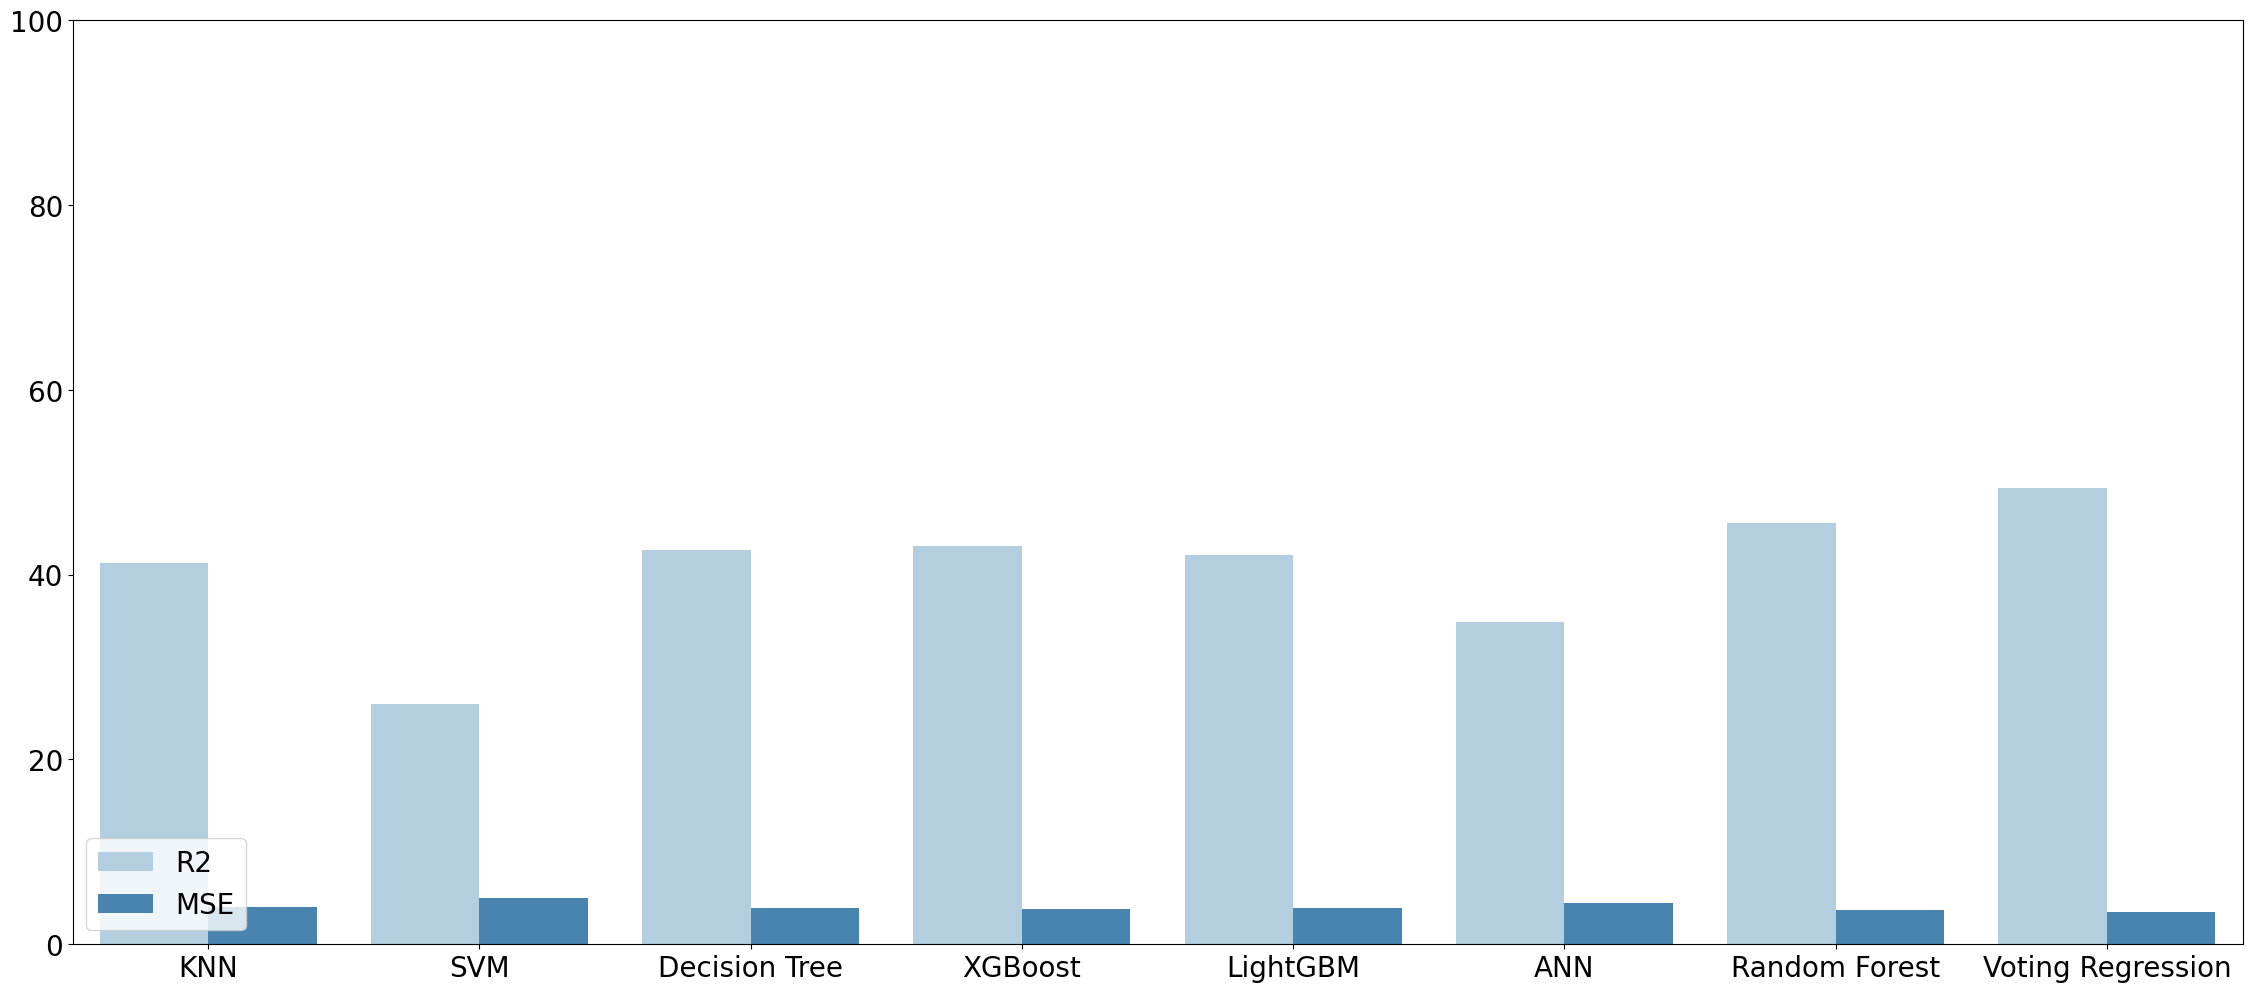

In [38]:
model_report = pd.DataFrame(columns=['Model', 'R2', 'MSE'])

for initial in model_y_predict:
    r2 = r2_score(model_y_true['value'], model_y_predict[initial]) * 100
    mse = mean_squared_error(model_y_true['value'], model_y_predict[initial])
    
    report = pd.DataFrame({'Model': [initial_model_name[initial]],
                           'R2': [r2],
                           'MSE': [mse]})
    
    model_report = pd.concat([model_report, report], axis=0, ignore_index=False)

display(model_report)

model_report.to_csv(f'Model_Report-Regression.csv', index=False)

model_report = pd.melt(model_report, id_vars=['Model'], var_name='Metric', value_name='Value')

plt.figure(figsize=(28, 12))
axis = sns.barplot(model_report, 
            x='Model', 
            y='Value', 
            hue='Metric', 
            palette=sns.color_palette('Blues', 2))

plt.ylim(0, 100)

axis.set(xlabel=None)
plt.xticks(fontsize=20)
axis.set(ylabel=None)
plt.yticks(fontsize=20)

plt.legend(loc='lower left', fontsize=20)

plt.savefig('model_report.pdf', dpi=600, bbox_inches='tight') 
plt.savefig('model_report.png', dpi=600, bbox_inches='tight')

plt.show()

# Dependence Dataset Prediction

,index,no,value,KNN,SVM,DT,XGB,LGBM,ANN,RF,VC
0,4.0,NaN,22.623871,17.980105,19.103015,19.143884,19.250616,18.851136,19.357961,19.451952,19.053040
1,10.0,83.0,17.500000,15.829002,16.838975,16.689683,16.825260,16.474713,14.825778,16.300974,16.323089
2,11.0,NaN,18.071887,17.593127,17.641708,18.916076,18.757795,18.854747,18.490109,18.176173,18.409721
3,30.0,147.0,19.125000,18.052460,18.337720,18.916076,18.563135,18.721496,19.352141,18.853084,18.663284
4,45.0,25.0,18.000000,18.593127,19.729318,18.916076,19.975849,19.039665,21.209147,19.576777,19.600034
...,...,...,...,...,...,...,...,...,...,...,...
102,74.0,NaN,13.499212,19.000000,18.709250,20.268238,19.152740,19.434373,19.951270,18.293505,19.155374
103,82.0,142.0,16.375000,16.644839,16.574057,16.043005,14.848338,15.041401,15.894742,15.640505,15.605946
104,86.0,58.0,16.750000,17.768539,17.396074,16.043005,16.818993,17.140731,17.136183,16.420650,16.896904
105,92.0,NaN,12.385958,16.092816,17.232845,16.043005,17.342087,17.208318,16.548495,16.767858,16.811744


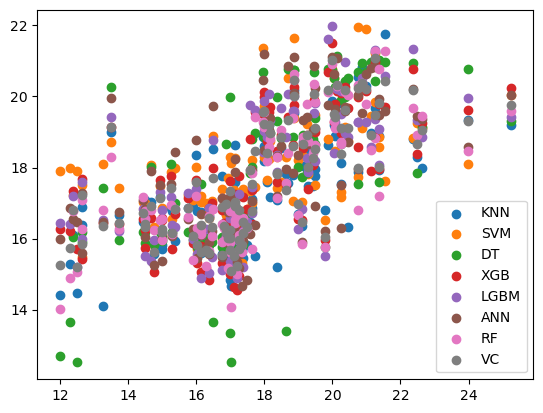

In [51]:
count_prediction = pd.DataFrame({'index': model_y_true['index'],
                                 'no': model_y_true['no'],
                                 'value': model_y_true['value']})

for initial in model_y_predict:
    count_prediction[initial] = model_y_predict[initial]

display(count_prediction)

for initial in model_y_predict:
    plt.scatter(count_prediction['value'], count_prediction[initial], label=initial)

plt.legend(loc='best')
plt.show()

## True Prediction

In [ ]:
positive_prediction = count_prediction[count_prediction['Prediction Rate'] >= 0.5]
true_positive_prediction = positive_prediction[positive_prediction['value'] == 1]

print('Positive Class:', true_positive_prediction.shape)

# display(true_positive_prediction)

negative_prediction = count_prediction[count_prediction['Prediction Rate'] < 0.5]
true_negative_prediction = negative_prediction[negative_prediction['value'] == 0]

print('Negative Class:', true_negative_prediction.shape)

# display(false_negative_prediction)

true_prediction = pd.concat([true_positive_prediction, true_negative_prediction])

display(true_prediction)

print('Shape: ', true_prediction.shape)

# true_prediction.to_csv(f'TruePrediction-{int(num) + 1}.csv')

In [ ]:
good_dataset = df.loc[true_prediction['index'].tolist(), :]

display(good_dataset)

if export_good_bad_dataset:
    good_dataset.to_csv(f'GoodDataset-{int(num) + 1}.csv', index=False)

## False Prediction

In [ ]:
positive_prediction = count_prediction[count_prediction['Prediction Rate'] >= 0.5]
false_positive_prediction = positive_prediction[positive_prediction['value'] == 0]

# display(true_positive_prediction)

negative_prediction = count_prediction[count_prediction['Prediction Rate'] < 0.5]
false_negative_prediction = negative_prediction[negative_prediction['value'] == 1]

# display(false_negative_prediction)

false_prediction = pd.concat([false_positive_prediction, false_negative_prediction])

display(false_prediction)

print('Shape: ', false_prediction.shape)

# false_prediction.to_csv(f'FalsePrediction-{int(num) + 1}.csv')

In [ ]:
bad_dataset = df.loc[false_prediction['index'].tolist(), :]

display(bad_dataset)

if export_good_bad_dataset:
    bad_dataset.to_csv(f'BadDataset-{int(num) + 1}.csv', index=False)